In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import radians
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
data = pd.read_csv('../data/ntsb/cleaned/master_train.csv')
data = data.loc[(~data['damage'].isna()) & (~data['latitude'].isna())]

In [3]:
# Baseline model: predict majority
# baseline_preds = np.zeros(shape=(len(data),4))
# baseline_preds[:,2] = np.ones(shape=(len(data)))

baseline_preds = ['SUBS']*len(data)

In [4]:
def reformat_latitude_longitude(str):
    '''
    Takes string xxxxxxY where:
        x are digits (implied decimal after second digit)
        Y is N/S/E/W 
    Returns latitude/longitude in radians
    '''
    num_as_float = float(str[0:2]+'.'+str[2:-1])
    rads = radians(num_as_float)

    if str[-1] == 'S' or str[-1] == 'W':
        return -rads
    else:
        return rads

In [5]:
#Reformat latitude + longitude to radians; needed for Haversine metric
data['longitude'] = data['longitude'].apply(reformat_latitude_longitude)
data['latitude'] = data['latitude'].apply(reformat_latitude_longitude)

In [6]:
# Shuffle the data
# Note that GridSearchCV does not shuffle the data before doing StratifiedKFold split
data_shuffled = data.sample(frac=1)

X = data_shuffled[['latitude','longitude']]
y = data_shuffled['damage']

params = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,15,20,25,30]}

grid_search = GridSearchCV(
    KNeighborsClassifier(metric='haversine'),
    params,
    scoring='f1_macro',
    cv=5
)

grid_search.fit(X,y)

,estimator,KNeighborsCla...c='haversine')
,param_grid,"{'n_neighbors': [1, 2, ...]}"
,scoring,'f1_macro'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,1


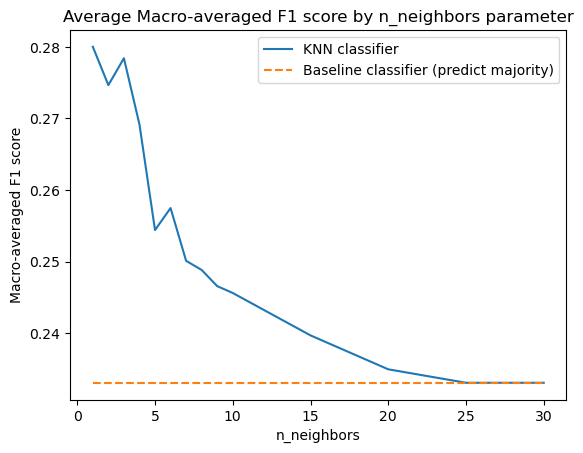

In [7]:
# Get macro-average F1 scores for baseline model and KNN for each parameter value
baseline_score = f1_score(y, baseline_preds, average='macro')
results_df = pd.DataFrame(grid_search.cv_results_)

# Plot macro-average F1 scores
plt.plot(results_df['param_n_neighbors'], results_df['mean_test_score'], label='KNN classifier')
plt.plot(results_df['param_n_neighbors'], baseline_score * np.ones(len(results_df)), 
         label='Baseline classifier (predict majority)', linestyle='--')

# Label the graph
plt.xlabel('n_neighbors')
plt.ylabel('Macro-averaged F1 score')
plt.title('Average Macro-averaged F1 score by n_neighbors parameter')
plt.legend()

plt.show()

### CV Results

I ran the cell above several times to get different shuffles of the dataset. It usually had the highest macro-averaged F1 for `n_neighbors = 3`

In [8]:
# Get the confusion matrix on the training data

knn = KNeighborsClassifier(n_neighbors=3, 
                           metric='haversine')

knn.fit(X,y)

preds = knn.predict(X)
np.unique(preds, return_counts=True)

confusion_matrix(y, preds)

array([[  299,     0,   808,     5],
       [   16,    14,    79,     0],
       [  160,    14, 11713,    45],
       [   72,     6,   332,   103]])